In [1]:
import edward as ed
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [10]:
from edward.models import Bernoulli, Beta
plt.style.use('ggplot')

Let's try the coin fliping toy example again and see how different be between these estimation settings.

## KLpq:beta

In [12]:
x_data = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

# MODEL
p = Beta(1.0, 1.0)
x = Bernoulli(tf.ones(10) * p)

# INFERENCE
qp_a = tf.nn.softplus(tf.Variable(tf.random_normal([])))
qp_b = tf.nn.softplus(tf.Variable(tf.random_normal([])))
qp = Beta(qp_a, qp_b)

inference = ed.KLqp({p: qp}, data={x: x_data})
inference.run(n_iter=500)


500/500 [100%] ██████████████████████████████ Elapsed: 0s | Loss: 8.842


(array([ 1.87555907,  1.65914841,  1.59731679,  1.36029559,  1.08205331,
         0.84503211,  0.78320049,  0.49465294,  0.42251605,  0.18549485]),
 array([  1.83041717e-04,   9.72207747e-02,   1.94258508e-01,
          2.91296241e-01,   3.88333974e-01,   4.85371707e-01,
          5.82409440e-01,   6.79447173e-01,   7.76484906e-01,
          8.73522639e-01,   9.70560372e-01]),
 <a list of 10 Patch objects>)

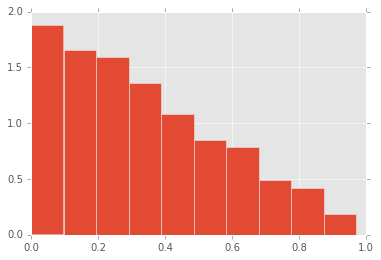

In [16]:
plt.hist(qp.sample(1000).eval(),normed=True)

In [25]:
def pdf_from_cdf(x,cdf):
    return (cdf[1:] - cdf[:-1])/(x[1:]-x[:-1])

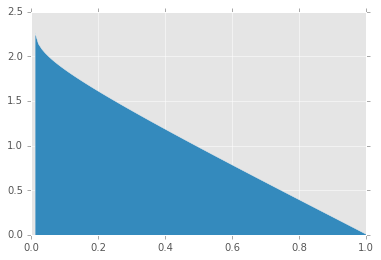

In [26]:
x = np.linspace(0,1,100,dtype='float32')
plt.fill_between(x[1:], pdf_from_cdf(x,qp.cdf(x).eval()))

## KLpq: sigmoid-normal

In [44]:
ds = tf.contrib.distributions

x_data = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

# MODEL
p = Beta(1.0, 1.0)
x = Bernoulli(tf.ones(10) * p)

# INFERENCE
qp_mu = tf.Variable(tf.random_normal([]))
qp_sigma = tf.nn.softplus(tf.Variable(tf.random_normal([])))

# You can not use tensorflow math function to produce a new distribution directly. So the latent variable is poor too.
sigmoid_normal = ed.models.TransformedDistribution( 
    distribution=ds.Normal(loc=qp_mu, scale=qp_sigma),
    bijector=ds.bijectors.Sigmoid(),
    name="SomedDistribution"
)

qp = sigmoid_normal
#qp = 1/tf.exp(-ed.models.Normal(qp_mu, qp_sigma))

inference = ed.KLqp({p: qp}, data={x: x_data})
inference.run(n_iter=500)


500/500 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 8.488


(array([ 3.92997966,  2.58639687,  1.36597583,  1.14204537,  0.75016706,
         0.61580878,  0.36948527,  0.22393046,  0.12316176,  0.08957219]),
 array([ 0.00297888,  0.09229232,  0.18160576,  0.2709192 ,  0.36023264,
         0.44954608,  0.53885952,  0.62817296,  0.7174864 ,  0.80679984,
         0.89611328]),
 <a list of 10 Patch objects>)

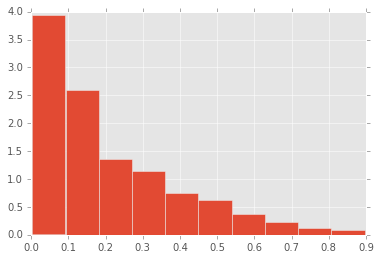

In [45]:
plt.hist(qp.sample(1000).eval(),normed=True)

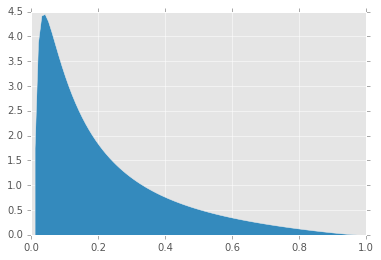

In [46]:
x = np.linspace(0,1,100,dtype='float32')
plt.fill_between(x[1:], pdf_from_cdf(x,qp.cdf(x).eval()))

## MCMC:MetropolisHastings

For Monte Carlo algorithm, indicating `n_iter` is uesless, the true "n_iter" would be determined by 
the dims of qx Empirical variable (default 10000, in below case 1000)

In [58]:
from edward.models import Empirical

# DATA
x_data = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

# MODEL
p = Beta(1.0, 1.0)
x = Bernoulli(tf.ones(10) * p)

# INFERENCE
qp = Empirical(params=tf.Variable(tf.zeros([1000]) + 0.5))

proposal_p = Beta(3.0, 9.0)

inference = ed.MetropolisHastings({p: qp}, {p: proposal_p}, data={x: x_data})
inference.run()

# CRITICISM
# exact posterior has mean 0.25 and std 0.12
sess = ed.get_session()
mean, stddev = sess.run([qp.mean(), qp.stddev()])
print("Inferred posterior mean:")
print(mean)
print("Inferred posterior stddev:")
print(stddev)


1000/1000 [100%] ██████████████████████████████ Elapsed: 1s | Acceptance Rate: 0.726
Inferred posterior mean:
0.204096
Inferred posterior stddev:
0.0806205


(array([  19.,   92.,  192.,  210.,  198.,  152.,   58.,   54.,   21.,    4.]),
 array([ 0.02378478,  0.06718663,  0.11058849,  0.15399035,  0.1973922 ,
         0.24079406,  0.28419591,  0.32759777,  0.37099963,  0.41440148,
         0.45780334]),
 <a list of 10 Patch objects>)

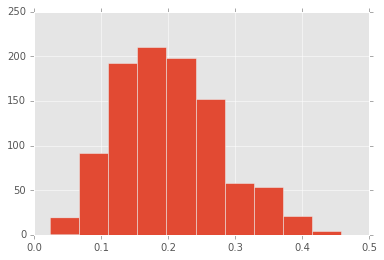

In [59]:
plt.hist(qp.sample(1000).eval())

The `sample` is `sample` of `sample`, while the paramers of the `qp`, the trace of HM algorithm is more favorite.

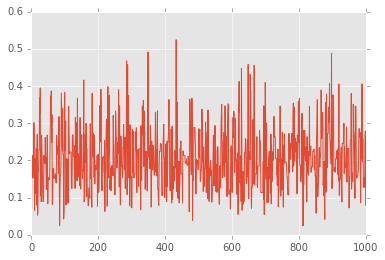

In [60]:
plt.plot(qp.params.eval())

Looks there's not a significant burn-in stage occured, we can use the params vaildly.

(array([ 0.47940275,  3.05619255,  3.91512248,  5.0337289 ,  4.11487363,
         1.57803406,  1.17853177,  0.43945252,  0.11985069,  0.05992534]),
 array([ 0.02378478,  0.07384707,  0.12390936,  0.17397165,  0.22403394,
         0.27409623,  0.32415852,  0.37422081,  0.4242831 ,  0.47434539,
         0.52440768]),
 <a list of 10 Patch objects>)

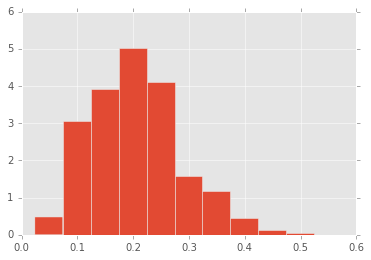

In [63]:
plt.hist(qp.params.eval(),normed=True)

So, the Monte Carlo and Variational inference get vrey different result. Which one should we believe?

In [66]:
from edward.models import Empirical

# DATA
x_data = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

# MODEL
p = Beta(1.0, 1.0)
x = Bernoulli(tf.ones(10) * p)

# INFERENCE
qp = Empirical(params=tf.Variable(tf.zeros([20000]) + 0.5))

proposal_p = Beta(3.0, 9.0)

inference = ed.MetropolisHastings({p: qp}, {p: proposal_p}, data={x: x_data})
inference.run()

# CRITICISM
# exact posterior has mean 0.25 and std 0.12
sess = ed.get_session()
mean, stddev = sess.run([qp.mean(), qp.stddev()])
print("Inferred posterior mean:")
print(mean)
print("Inferred posterior stddev:")
print(stddev)


20000/20000 [100%] ██████████████████████████████ Elapsed: 9s | Acceptance Rate: 0.730
Inferred posterior mean:
0.203167
Inferred posterior stddev:
0.0807837


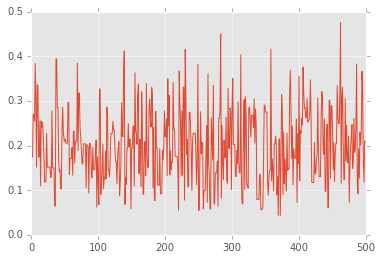

In [70]:
plt.plot(qp.params.eval()[:500])

(array([  1.29438328e-01,   9.35804125e-01,   2.15147490e+00,
          3.53331651e+00,   4.65803062e+00,   4.80321145e+00,
          4.91340895e+00,   4.22423731e+00,   3.14500153e+00,
          2.40685323e+00,   1.54976160e+00,   1.04949995e+00,
          6.82174969e-01,   4.30294981e-01,   1.90659158e-01,
          9.27058292e-02,   4.72274979e-02,   2.44883322e-02,
          1.22441661e-02,   3.49833318e-03]),
 array([ 0.01676068,  0.04534572,  0.07393077,  0.10251581,  0.13110085,
         0.15968589,  0.18827093,  0.21685598,  0.24544102,  0.27402606,
         0.3026111 ,  0.33119614,  0.35978118,  0.38836623,  0.41695127,
         0.44553631,  0.47412135,  0.50270639,  0.53129143,  0.55987648,
         0.58846152]),
 <a list of 20 Patch objects>)

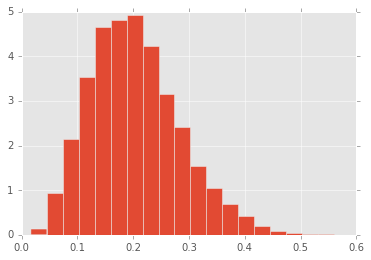

In [72]:
plt.hist(qp.params.eval(),normed=True,bins=20)

In [ ]:
ds = tf.contrib.distributions

x_data = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

# MODEL
p = Beta(1.0, 1.0)
x = Bernoulli(tf.ones(10) * p)

# INFERENCE
qp_mu = tf.Variable(tf.random_normal([]))
qp_sigma = tf.nn.softplus(tf.Variable(tf.random_normal([])))

# You can not use tensorflow math function to produce a new distribution directly. So the latent variable is poor too.
sigmoid_normal = ed.models.TransformedDistribution( 
    distribution=ds.Normal(loc=qp_mu, scale=qp_sigma),
    bijector=ds.bijectors.Sigmoid(),
    name="SomedDistribution"
)

qp = sigmoid_normal
#qp = 1/tf.exp(-ed.models.Normal(qp_mu, qp_sigma))

inference = ed.KLqp({p: qp}, data={x: x_data})
inference.run(n_iter=500)


In [73]:
ds.bijectors?

In [74]:
ed.complete_conditional?

In [76]:
ed.models.ConditionalDistributio?

Object `ed.models.ConditionalDistributio` not found.


In [78]:
ed.models.ConditionalDistribution?